# 1 正则化线性回归
这一部分，我们需要先对一个水库的流出水量以及水库水位进行正则化线性归回。然后将会探讨方差-偏差的问题

## 1.1 数据可视化

In [19]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
data = sio.loadmat('E:\机器学习(吴恩达)\ML数据\ml_ex5\ex5data1.mat')
X, y, Xval, yval, Xtest, ytest = map(np.ravel,[data['X'], data['y'], data['Xval'], data['yval'], data['Xtest'], data['ytest']])
X.shape, y.shape, Xval.shape, yval.shape, Xtest.shape, ytest.shape

((12,), (12,), (21,), (21,), (21,), (21,))

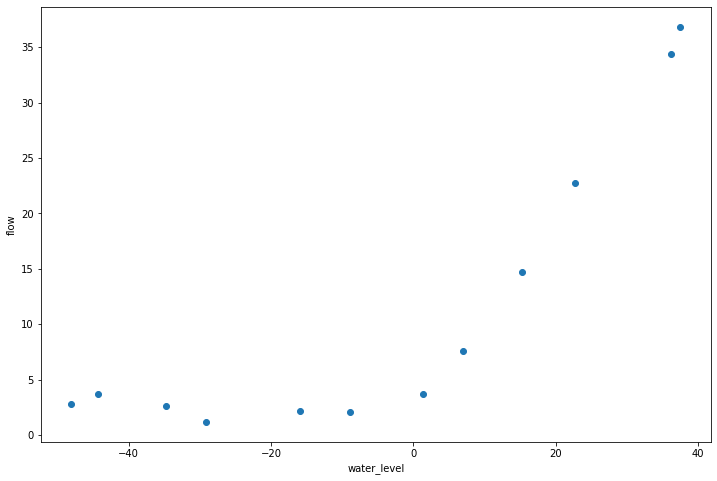

In [21]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X, y)
ax.set_xlabel('water_level')
ax.set_ylabel('flow')
plt.show()

## 1.2 正则化线性回归代价函数

其中$\lambda$是正则化参数，他控制了正则化的程度。正则化项在原来的代价$J$上加了一个惩罚项。随着参数$\theta_j$的变大，惩罚项也会增大。另外，你不需要正则化$\theta_0$
下面完场计算正则化线性回归代价函数的代码。theta初始值为[1,1]，输出应该为303.993

In [22]:
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]

In [23]:
def cost(theta, X, y):
    m = X.shape[0]

    inner = X @ theta - y 

    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)

    return cost

In [24]:
def costReg(theta, X, y, reg = 1):
    
    m = X.shape[0]

    regularized_term = (reg / (2 * m)) * np.power(theta[1:], 2).sum()

    return cost(theta, X, y) + regularized_term

In [25]:
theta = np.ones(X.shape[1])
costReg(theta, X, y, 1)

303.9931922202643

## 1.3 正则化线性回归的梯度

In [26]:
def gradient(theta, X, y):
    m = X.shape[0]

    inner = X.T @ (X @ theta - y)  # (m,n).T @ (m, 1) -> (n, 1)

    return inner / m

In [27]:
def gradientReg(theta, X, y, reg):
    m = X.shape[0]

    regularized_term = theta.copy()  # same shape as theta
    regularized_term[0] = 0  # don't regularize intercept theta

    regularized_term = (reg / m) * regularized_term

    return gradient(theta, X, y) + regularized_term

In [28]:
gradientReg(theta, X, y, 1)


array([-15.30301567, 598.25074417])